# SUPERVISED MLP ON TCGA-BRCA 
Goal: train a simple MLP on the latent representations AE already implemented
-   Train/Test split already fixed from QC (patient-wise).
-	We split train → (train/val) only for model selection/early stopping.
-	Any encoder for labels is fit on train only.
-> Picking a target column from metadata is needed (check meta_train_postQC.csv)

In [165]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow import keras
from keras import layers

RANDOM_STATE = 42
tf.keras.utils.set_random_seed(SEED)


# To see where our files were stored
print("CWD:", os.getcwd())
print("Exists tcga_brca_repr ?", Path("./tcga_brca_repr").exists())
print("Files in tcga_brca_repr:", list(Path("./tcga_brca_repr").glob("*"))[:20])

CWD: /Users/soussouk/Documents/School/MASTER_COURSES/M2/AI:DL/My_project
Exists tcga_brca_repr ? True
Files in tcga_brca_repr: [PosixPath('tcga_brca_repr/ids_train_AE.npy'), PosixPath('tcga_brca_repr/.DS_Store'), PosixPath('tcga_brca_repr/Z_test_AE.npy'), PosixPath('tcga_brca_repr/Z_train_AE.npy'), PosixPath('tcga_brca_repr/ids_test_AE.npy')]


# Charger X fait suite au QC

In [166]:
X_train = np.load("./tcga_brca_repr/Z_train_AE.npy")
X_test  = np.load("./tcga_brca_repr/Z_test_AE.npy")

# tf/keras: float32 recommandé
X_train = np.asarray(X_train, dtype=np.float32)
X_test  = np.asarray(X_test, dtype=np.float32)

print("X_train:", X_train.shape, X_train.dtype)
print("X_test :", X_test.shape,  X_test.dtype)

X_train: (692, 32) float32
X_test : (208, 32) float32


But
-	Charger les features (probablement gènes) déjà pré-traitées.
-	Convertir en float32 (recommandé pour TF/Keras).

Entrées / Sorties
-	Entrées : fichiers .npy
-	Sorties : X_train, X_test prêts pour le modèle.

Les X sont déjà standardisé !

In [167]:
print(meta_tr.columns.tolist())

['submitter_id', 'barcode', 'patient', 'sample', 'shortLetterCode', 'definition', 'sample_submitter_id', 'tumor_descriptor', 'sample_id', 'pathology_report_uuid', 'sample_type', 'specimen_type', 'days_to_collection', 'state', 'initial_weight', 'tissue_type', 'preservation_method', 'synchronous_malignancy', 'ajcc_pathologic_stage', 'days_to_diagnosis', 'laterality', 'tissue_or_organ_of_origin', 'age_at_diagnosis', 'primary_diagnosis', 'prior_malignancy', 'year_of_diagnosis', 'prior_treatment', 'diagnosis_is_primary_disease', 'method_of_diagnosis', 'ajcc_staging_system_edition', 'ajcc_pathologic_t', 'morphology', 'ajcc_pathologic_n', 'ajcc_pathologic_m', 'classification_of_tumor', 'diagnosis_id', 'icd_10_code', 'site_of_resection_or_biopsy', 'metastasis_at_diagnosis', 'days_to_last_follow_up', 'follow_ups_disease_response', 'race', 'gender', 'ethnicity', 'vital_status', 'age_at_index', 'days_to_birth', 'demographic_id', 'age_is_obfuscated', 'days_to_death', 'country_of_residence_at_enrol

# Charger les méta et définir les colonnes de survies

In [168]:
""" temps: days_to_last follow_up or days_to_death
event: vital_status (dead or alive)
"""

meta_tr = pd.read_csv("./tcga_brca_qc_report/meta_train_postQC.csv")
meta_te = pd.read_csv("./tcga_brca_qc_report/meta_test_postQC.csv")

#aligner méta et Z_train/test si besoin
ids_train = np.load(os.path.join( "tcga_brca_repr/ids_train_AE.npy"), allow_pickle=True).astype(str)
ids_test  = np.load(os.path.join("tcga_brca_repr/ids_test_AE.npy"),  allow_pickle=True).astype(str)

meta_tr = meta_tr.set_index("submitter_id").loc[ids_train].reset_index()
meta_te = meta_te.set_index("submitter_id").loc[ids_test].reset_index()

#===============================================================
# DEFINIR LES COLONNES DE SURVIE TIME ET EVENT
#===============================================================

# temps (en jours) et event (dead or alive)
TIME_COL = "days_to_last_follow_up"    # car days_to_death a bcp trop de NaN
EVENT_COL = "vital_status"  

if TIME_COL not in meta_tr.columns or EVENT_COL not in meta_tr.columns:
    raise ValueError(
        f"TIME_COL/EVENT_COL non trouvées dans meta.\n"
        f"Colonnes meta_tr (extrait): {meta_tr.columns.tolist()[:40]}"
    )

t_train = pd.to_numeric(meta_tr[TIME_COL], errors="coerce").values
e_train = pd.to_numeric(meta_tr[EVENT_COL], errors="coerce").values

t_test  = pd.to_numeric(meta_te[TIME_COL], errors="coerce").values
e_test  = pd.to_numeric(meta_te[EVENT_COL], errors="coerce").values

print("Survival train:", np.nanmin(t_train), np.nanmax(t_train), "events:", np.nansum(e_train))
print("Survival test :", np.nanmin(t_test),  np.nanmax(t_test),  "events:", np.nansum(e_test))


Survival train: -7.0 8605.0 events: 0.0
Survival test : 0.0 5156.0 events: 0.0


But
-	Charger meta_tr/meta_te.
-	Fixer :
-	TIME_COL = days_to_last_follow_up (choisi car days_to_death a trop de NaN, d’après ton commentaire).
-	EVENT_COL = vital_status (encore au format texte à ce stade).
-	Vérifier l’existence des colonnes.
-	Convertir TIME_COL et EVENT_COL en numérique pour un check rapide.

Entrée : CSV meta post-QC

Sorties : meta_tr, meta_te et des vecteurs t_train, e_train, etc. (mais e_train ici n’est pas encore correctement défini si vital_status est du texte).

# Standardiser vital_status et création de event (Cox)

In [169]:
# ============================================================
# Standardisation de vital_status + création de event (Cox)
# ============================================================

def standardize_vital_status(series):
    s = series.copy()

    # Cas numérique (0/1)
    s_num = pd.to_numeric(s, errors="coerce")
    vals = set(s_num.dropna().unique().tolist())
    if len(vals) > 0 and vals.issubset({0.0, 1.0}):
        return s_num

    # Cas texte ("Alive"/"Dead")
    s_txt = s.astype(str).str.strip().str.lower()
    return s_txt.map({"alive": 1, "dead": 0})


meta_tr["vital_status"] = standardize_vital_status(meta_tr["vital_status"])
meta_te["vital_status"] = standardize_vital_status(meta_te["vital_status"])

# Convention Cox : event = 1 si décès
meta_tr["event"] = 1 - meta_tr["vital_status"]
meta_te["event"] = 1 - meta_te["vital_status"]

print("vital_status train:")
print(meta_tr["vital_status"].value_counts(dropna=False))
print("vital_status test:")
print(meta_te["vital_status"].value_counts(dropna=False))

vital_status train:
vital_status
1.0    586
0.0    105
NaN      1
Name: count, dtype: int64
vital_status test:
vital_status
1    186
0     22
Name: count, dtype: int64


- vital_status = 1 → Alive
- vital_status = 0 → Dead
- donc event = 1 - vital_status → event=1 si décès

# Refaire l'alignement
Certains NaN on pu se glisser, on les supprime

In [170]:
TIME_COL = "days_to_last_follow_up"
EVENT_COL = "event"

time_tr  = pd.to_numeric(meta_tr[TIME_COL], errors="coerce")
event_tr = pd.to_numeric(meta_tr[EVENT_COL], errors="coerce")

mask_tr = time_tr.notna() & (time_tr > 0) & event_tr.notna() & event_tr.isin([0, 1])

X_train = X_train[mask_tr.values]
meta_tr = meta_tr.loc[mask_tr].reset_index(drop=True)

time_te  = pd.to_numeric(meta_te[TIME_COL], errors="coerce")
event_te = pd.to_numeric(meta_te[EVENT_COL], errors="coerce")

mask_te = time_te.notna() & (time_te > 0) & event_te.notna() & event_te.isin([0, 1])

X_test = X_test[mask_te.values]
meta_te = meta_te.loc[mask_te].reset_index(drop=True)

print("Aligned train:", X_train.shape, meta_tr.shape)
print("Aligned test :", X_test.shape, meta_te.shape)

Aligned train: (676, 32) (676, 91)
Aligned test : (206, 32) (206, 91)


In [171]:
# verifie le nombre de alive et dead après le mapping
print(meta_tr["vital_status"].value_counts(dropna=False))
print(meta_te["vital_status"].value_counts(dropna=False))

vital_status
1.0    573
0.0    103
Name: count, dtype: int64
vital_status
1    184
0     22
Name: count, dtype: int64


# Checker les NaN

In [172]:
# Check combien de NaN dans event et time restent et si event est bien en binaire
print("NaN event train:", meta_tr["event"].isna().sum())
print("NaN event test :", meta_te["event"].isna().sum())

print("Unique event train:", meta_tr["event"].dropna().unique()[:10])
print("Unique event test :", meta_te["event"].dropna().unique()[:10])

print("NaN time train:", meta_tr["days_to_last_follow_up"].isna().sum())
print("NaN time test :", meta_te["days_to_last_follow_up"].isna().sum())

NaN event train: 0
NaN event test : 0
Unique event train: [0. 1.]
Unique event test : [0 1]
NaN time train: 0
NaN time test : 0


In [173]:
assert meta_tr["event"].isna().sum() == 0
assert meta_te["event"].isna().sum() == 0
assert (meta_tr["days_to_last_follow_up"] > 0).all()
assert (meta_te["days_to_last_follow_up"] > 0).all()

print("Survival data clean and aligned ✔")

Survival data clean and aligned ✔


# Split intern /validation 
À vérifier
-	Event rate ≠ 0
-	X_val.shape[0] ≈ 10–20 % du train

In [174]:
val_frac = 0.15

n = X_train.shape[0]
idx = np.arange(n)
np.random.default_rng(RANDOM_STATE).shuffle(idx)

n_val = int(val_frac * n)
val_idx = idx[:n_val]
tr_idx  = idx[n_val:]

X_tr  = X_train[tr_idx]
X_val = X_train[val_idx]

t_tr  = meta_tr.iloc[tr_idx]["days_to_last_follow_up"].astype(np.float32).values
t_val = meta_tr.iloc[val_idx]["days_to_last_follow_up"].astype(np.float32).values

e_tr  = meta_tr.iloc[tr_idx]["event"].astype(np.float32).values
e_val = meta_tr.iloc[val_idx]["event"].astype(np.float32).values

print("Train:", X_tr.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)
print("Event rate (train):", e_tr.mean())

Train: (575, 32)
Val  : (101, 32)
Test : (206, 32)
Event rate (train): 0.14434783


But
-	Split aléatoire de X_train en X_tr et X_val.
-	Récupérer les labels de survie alignés via meta_tr.iloc[...].

# Loss Cox partial likelihood

In [175]:
def cox_ph_loss(t, e, r, eps=1e-8):
    t = tf.reshape(t, [-1])
    e = tf.reshape(e, [-1])
    r = tf.reshape(r, [-1])

    # tri par temps décroissant
    order = tf.argsort(t, direction="DESCENDING")
    e = tf.gather(e, order)
    r = tf.gather(r, order)

    # version stable numériquement (évite exp overflow)
    log_cum_sum_exp = tf.math.cumulative_logsumexp(r)

    pll = tf.reduce_sum(e * (r - log_cum_sum_exp))
    n_events = tf.reduce_sum(e) + eps
    return -pll / n_events

But
-	Implémenter la negative partial log-likelihood de Cox :
-	On trie par temps décroissant pour construire les “risk sets”.
-	log_cum_sum_exp approxime log(Σ exp(r_j)) sur le risk set.
-	On somme seulement sur les individus avec e=1 (décès).
-	On normalise par le nombre d’événements.

Ici, r est la sortie du réseau (score). La Cox ne prédit pas directement un temps, mais un ordre relatif de risque.

# MLP survie (baseline)

In [176]:
n_features = X_tr.shape[1]

inputs = keras.Input(shape=(n_features,))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)

risk = layers.Dense(1, activation=None)(x)

mlp = keras.Model(inputs, risk, name="MLP_Cox")
mlp.summary()

Model: "MLP_Cox"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

But
-	Réseau fully-connected qui produit un score de risque scalaire.
-	Dropout pour régulariser.

Entrée : vecteur de features (n_features,)

Sortie : risk de forme (batch, 1)

# stocker l'historique pour plotter cox loss (train/val)

In [177]:
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_cindex": [],
}

best_epoch = None

In [178]:
def harrell_c_index(t, e, risk):
    t = np.asarray(t).reshape(-1)
    e = np.asarray(e).reshape(-1)
    risk = np.asarray(risk).reshape(-1)

    concordant = 0.0
    permissible = 0.0
    ties = 0.0

    n = len(t)
    for i in range(n):
        if e[i] != 1:
            continue
        for j in range(n):
            if t[j] <= t[i]:
                continue
            permissible += 1
            if risk[i] > risk[j]:
                concordant += 1
            elif risk[i] == risk[j]:
                ties += 1

    if permissible == 0:
        return np.nan
    return (concordant + 0.5 * ties) / permissible

# Entrainement MLP

In [179]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)

@tf.function
def train_step(x, t, e):
    with tf.GradientTape() as tape:
        r = mlp(x, training=True)
        loss = cox_ph_loss(t, e, r)
    grads = tape.gradient(loss, mlp.trainable_weights)
    optimizer.apply_gradients(zip(grads, mlp.trainable_weights))
    return loss

@tf.function
def val_step(x, t, e):
    r = mlp(x, training=False)
    return cox_ph_loss(t, e, r)

BATCH = 64
EPOCHS = 200
PATIENCE = 15

best_val = np.inf
pat = 0

for epoch in range(1, EPOCHS + 1):

    # ---- TRAIN ----
    idx = np.arange(X_tr.shape[0])
    np.random.default_rng(SEED).shuffle(idx)

    tr_losses = []
    for i in range(0, len(idx), BATCH):
        j = idx[i:i+BATCH]
        tr_losses.append(
            float(train_step(X_tr[j], t_tr[j], e_tr[j]).numpy())
        )
    tr_loss = np.mean(tr_losses)

    # ---- VALIDATION ----
    val_losses = []
    for i in range(0, X_val.shape[0], BATCH):
        val_losses.append(
            float(val_step(
                X_val[i:i+BATCH],
                t_val[i:i+BATCH],
                e_val[i:i+BATCH]
            ).numpy())
        )
    va_loss = np.mean(val_losses)

    # Compute Harrell's C-index on validation set# C-index sur validation (plus grand = mieux)
    risk_val = mlp(X_val, training=False).numpy().reshape(-1)
    cidx_val = harrell_c_index(t_val, e_val, risk_val)

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_cindex"].append(cidx_val)

    print(f"Epoch {epoch:03d} | train={tr_loss:.4f} | val={va_loss:.4f} | val_cindex={cidx_val:.4f}")

    print(f"Epoch {epoch:03d} | train={tr_loss:.4f} | val={va_loss:.4f}")

    if va_loss < best_val - 1e-4:
        best_val = va_loss
        best_epoch = epoch
        pat = 0
        mlp.save("best_mlp_cox.keras")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping")
            break

Epoch 001 | train=82.4517 | val=47.0301 | val_cindex=0.4770
Epoch 001 | train=82.4517 | val=47.0301
Epoch 002 | train=70.2188 | val=45.4632 | val_cindex=0.4663
Epoch 002 | train=70.2188 | val=45.4632
Epoch 003 | train=69.1321 | val=43.5794 | val_cindex=0.4535
Epoch 003 | train=69.1321 | val=43.5794
Epoch 004 | train=55.5825 | val=42.0230 | val_cindex=0.4364
Epoch 004 | train=55.5825 | val=42.0230
Epoch 005 | train=60.5983 | val=40.4770 | val_cindex=0.4203
Epoch 005 | train=60.5983 | val=40.4770
Epoch 006 | train=53.0950 | val=39.2384 | val_cindex=0.4235
Epoch 006 | train=53.0950 | val=39.2384
Epoch 007 | train=63.6236 | val=38.2821 | val_cindex=0.4128
Epoch 007 | train=63.6236 | val=38.2821
Epoch 008 | train=49.4758 | val=38.1087 | val_cindex=0.4096
Epoch 008 | train=49.4758 | val=38.1087
Epoch 009 | train=54.4517 | val=37.4360 | val_cindex=0.4021
Epoch 009 | train=54.4517 | val=37.4360
Epoch 010 | train=55.1040 | val=36.9193 | val_cindex=0.4000
Epoch 010 | train=55.1040 | val=36.9193


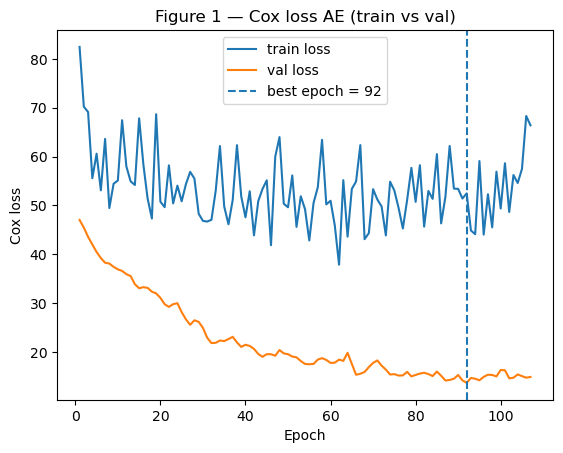

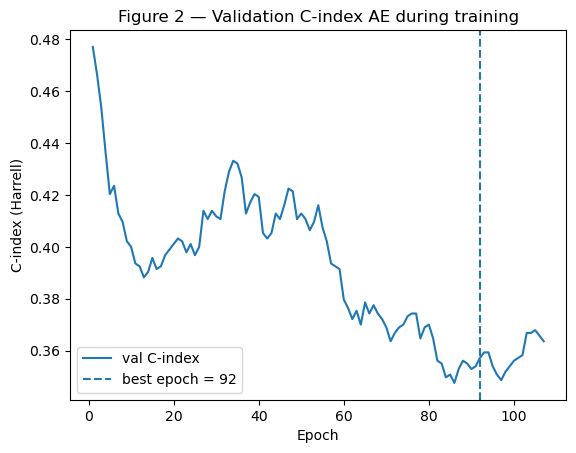

In [180]:
# ---- Figure 1: Cox loss curves ----
plt.figure()
plt.plot(history["epoch"], history["train_loss"], label="train loss")
plt.plot(history["epoch"], history["val_loss"], label="val loss")
if best_epoch is not None:
    plt.axvline(best_epoch, linestyle="--", label=f"best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Cox loss")
plt.title("Figure 1 — Cox loss AE (train vs val)")
plt.legend()
plt.show()

# ---- Figure 2: Validation C-index over epochs ----
plt.figure()
plt.plot(history["epoch"], history["val_cindex"], label="val C-index")
if best_epoch is not None:
    plt.axvline(best_epoch, linestyle="--", label=f"best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("C-index (Harrell)")
plt.title("Figure 2 — Validation C-index AE during training")
plt.legend()
plt.show()

# Evaluation sur le C-index

In [181]:
best = keras.models.load_model("best_mlp_cox.keras", compile=False)

risk_test = best.predict(X_test, batch_size=256).reshape(-1)

t_test = meta_te["days_to_last_follow_up"].astype(np.float32).values
e_test = meta_te["event"].astype(np.float32).values

def harrell_c_index(t, e, risk):
    n = len(t)
    num = 0.0
    den = 0.0
    for i in range(n):
        if e[i] != 1:
            continue
        for j in range(n):
            if t[j] > t[i]:
                den += 1
                if risk[i] > risk[j]:
                    num += 1
                elif risk[i] == risk[j]:
                    num += 0.5
    return num / den if den > 0 else np.nan

cidx = harrell_c_index(t_test, e_test, risk_test)
print("Test C-index:", cidx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Test C-index: 0.48066298342541436


But
-	Charger le meilleur modèle sauvegardé.
-	Prédire un score de risque sur le test.
-	Calculer le C-index :
	-	On ne compare que des paires “comparables” où l’un a eu l’événement (e[i]==1) et où l’autre a un temps plus long (t[j] > t[i]).
	-	Concordant si risk[i] > risk[j] (celui qui meurt plus tôt a un risque plus élevé).
	-	Gestion des égalités à 0.5.

# Export des données pour analyse biologique

In [182]:
# ============================================================
# Export des risk scores — MLP BASELINE (TEST uniquement)
# ============================================================

import os
import numpy as np
import pandas as pd

EXPORT_DIR = "./results_risk"
os.makedirs(EXPORT_DIR, exist_ok=True)

RUN_NAME = "MLP_AE"
ID_COL = "submitter_id"
TIME_COL = "days_to_last_follow_up"
EVENT_COL = "event"

df_test = pd.DataFrame({
    ID_COL: meta_te[ID_COL].astype(str).values,
    "split": "test",
    "risk_score": np.asarray(risk_test).reshape(-1),
    "time": meta_te[TIME_COL].astype(float).values,
    "event": meta_te[EVENT_COL].astype(int).values
})

out_path = os.path.join(EXPORT_DIR, f"{RUN_NAME}_risk_test.csv")
df_test.to_csv(out_path, index=False)

# optionnel : risk_all = risk_test (cohérence avec les autres runs)
df_test.to_csv(os.path.join(EXPORT_DIR, f"{RUN_NAME}_risk_all.csv"), index=False)

print("Saved:", out_path)

Saved: ./results_risk/MLP_AE_risk_test.csv


# GO enrichment

In [ ]:
# ============================================================
# GO ENRICHMENT 
# Gère l'alignement des échantillons entre QC et AE


import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# ============================================================
# Configuration

RUN_NAME = "MLP_AE"  

OUTDIR = f"./interpretation_{RUN_NAME}"
os.makedirs(OUTDIR, exist_ok=True)

TOP_N = 300
DO_GO = True

# ============================================================
# Charger les données
print("="*60)
print("GO ENRICHMENT FOR AUTOENCODER MODEL")
print("="*60)

# 1. Charger X_test ORIGINAL du QC (10,000 gènes)
X_test_genes_full = np.load("./tcga_brca_qc_report/X_test_z.npy")
meta_test_qc = pd.read_csv("./tcga_brca_qc_report/meta_test_postQC.csv")

print(f"\n1. QC data:")
print(f"   X_test shape: {X_test_genes_full.shape}")
print(f"   Meta test: {len(meta_test_qc)} samples")

# 2. Charger gene names
gene_names_path = "./tcga_brca_qc_report/gene_names.npy"
if not os.path.exists(gene_names_path):
    raise FileNotFoundError(
        f"Missing {gene_names_path}. "
        "Please run QC notebook with gene_names saving code!"
    )

gene_names = np.load(gene_names_path, allow_pickle=True).astype(str)
print(f"   Gene names: {len(gene_names)}")

# 3. Données du notebook actuel (AE)
# meta_te et risk_test sont déjà chargés dans le notebook
print(f"\n2. Current AE model data:")
print(f"   Meta test (AE): {len(meta_te)} samples")
print(f"   Risk scores: {len(risk_test)}")

# ============================================================
# ALIGNER les échantillons
# 
print(f"\n3. Aligning samples...")

# IDs des échantillons dans le modèle AE actuel
sample_ids_ae = meta_te["submitter_id"].astype(str).values

# IDs des échantillons du QC
meta_test_qc["submitter_id"] = meta_test_qc["submitter_id"].astype(str)

# Trouver les indices correspondants dans X_test du QC
indices_in_qc = []
for sid in sample_ids_ae:
    idx = meta_test_qc[meta_test_qc["submitter_id"] == sid].index
    if len(idx) > 0:
        indices_in_qc.append(idx[0])
    else:
        raise ValueError(f"Sample {sid} from AE not found in QC meta!")

# Extraire les lignes correspondantes
X_test_genes_aligned = X_test_genes_full[indices_in_qc, :]

print(f"   Aligned X_test shape: {X_test_genes_aligned.shape}")
print(f"   Expected: ({len(sample_ids_ae)}, {len(gene_names)})")

# Vérification
assert X_test_genes_aligned.shape[0] == len(sample_ids_ae), "Sample count mismatch!"
assert X_test_genes_aligned.shape[1] == len(gene_names), "Gene count mismatch!"

print(f"    Alignment successful!")

# ============================================================
# Créer DataFrame
# 
expr_df = pd.DataFrame(
    X_test_genes_aligned,
    index=sample_ids_ae,
    columns=gene_names
)

print(f"\n✓ Expression DataFrame: {expr_df.shape}")
print(f"  First 5 genes: {list(gene_names[:5])}")
print(f"  First 3 samples: {list(sample_ids_ae[:3])}")

# ============================================================
# Calculer corrélations

print("\n" + "="*60)
print("Calculating gene-risk correlations...")
print("="*60)

rows = []
for i, gene in enumerate(gene_names):
    if i % 1000 == 0:
        print(f"  Progress: {i}/{len(gene_names)} genes...")
    
    gene_expr = expr_df[gene].values
    r, pval = spearmanr(gene_expr, risk_test)
    rows.append((gene, r, pval))

rank_df = pd.DataFrame(rows, columns=["gene", "spearman_r", "pvalue"])
rank_df["abs_r"] = rank_df["spearman_r"].abs()
rank_df["qvalue"] = multipletests(rank_df["pvalue"].values, method="fdr_bh")[1]
rank_df = rank_df.sort_values("abs_r", ascending=False).reset_index(drop=True)

# Sauvegarder
out_rank = os.path.join(OUTDIR, "gene_risk_correlation.csv")
rank_df.to_csv(out_rank, index=False)
print(f"\n✓ Saved full gene ranking: {out_rank}")

# ============================================================
# Top gènes
top_genes = rank_df["gene"].head(TOP_N).tolist()
out_top = os.path.join(OUTDIR, f"top_{TOP_N}_genes.txt")
with open(out_top, "w") as f:
    f.write("\n".join(top_genes))

print(f"✓ Saved top {TOP_N} genes: {out_top}")

# Afficher top 10
print(f"\nTop 10 genes correlated with {RUN_NAME} risk score:")
print(f"{'Rank':<6} {'Gene':<15} {'Spearman r':<12} {'P-value':<12} {'Q-value':<12}")
print("-" * 60)
for i, gene in enumerate(top_genes[:10], 1):
    row = rank_df[rank_df["gene"] == gene].iloc[0]
    print(f"{i:<6} {gene:<15} {row['spearman_r']:>+10.4f}  {row['pvalue']:>10.2e}  {row['qvalue']:>10.2e}")

# Statistiques
sig_genes = rank_df[rank_df["qvalue"] < 0.05]
pos_corr = sig_genes[sig_genes["spearman_r"] > 0]
neg_corr = sig_genes[sig_genes["spearman_r"] < 0]

print(f"\nStatistics:")
print(f"  Total genes analyzed: {len(rank_df)}")
print(f"  Significant genes (FDR < 0.05): {len(sig_genes)}")
print(f"    - Positively correlated (high expr → high risk): {len(pos_corr)}")
print(f"    - Negatively correlated (high expr → low risk): {len(neg_corr)}")

# ============================================================
# GO Enrichment
if DO_GO:
    try:
        import gseapy as gp
        
        print("\n" + "="*60)
        print("Running GO enrichment...")
        print("="*60)
        
        GO_LIBRARY = "GO_Biological_Process_2021"
        go_outdir = os.path.join(OUTDIR, "go_enrichr")
        os.makedirs(go_outdir, exist_ok=True)
        
        enr = gp.enrichr(
            gene_list=top_genes,
            gene_sets=[GO_LIBRARY],
            organism="Human",
            outdir=go_outdir,
            cutoff=0.05
        )
        
        if hasattr(enr, "results") and enr.results is not None and len(enr.results) > 0:
            out_go = os.path.join(OUTDIR, "go_enrichment.csv")
            enr.results.to_csv(out_go, index=False)
            print(f"\n✓ Saved GO enrichment results: {out_go}")
            print(f"  Found {len(enr.results)} significant GO terms (FDR < 0.05)")
            
            # Top 5 termes
            print("\nTop 5 enriched biological processes:")
            print(f"{'Rank':<6} {'Term':<50} {'P-value':<12} {'Genes'}")
            print("-" * 100)
            for i, row in enr.results.head(5).iterrows():
                term = row['Term'][:47] + "..." if len(row['Term']) > 50 else row['Term']
                genes = row['Genes'][:30] + "..." if len(row['Genes']) > 30 else row['Genes']
                print(f"{i+1:<6} {term:<50} {row['P-value']:>10.2e}  {genes}")
        else:
            print("\n   No significant GO terms found (FDR < 0.05)")
            
    except ImportError:
        print("\n   gseapy not installed. Skipping GO enrichment.")
        print("   Install with: pip install gseapy")
    except Exception as e:
        print(f"\n GO enrichment failed: {e}")

# ============================================================
# Summary
print("\n" + "="*60)
print(f"✓ Biological interpretation completed for {RUN_NAME}")
print(f"  Results directory: {OUTDIR}")
print(f"  - Gene ranking: gene_risk_correlation.csv")
print(f"  - Top genes: top_{TOP_N}_genes.txt")
if DO_GO:
    print(f"  - GO enrichment: go_enrichment.csv")
print("\nInterpretation:")
print(f"  Analyzed {len(sample_ids_ae)} samples")
print("  Correlated ORIGINAL gene expression (10k genes)")
print("  with risk predicted by AE-based model (trained on 32D latent space)")
print("="*60 + "\n")


GO ENRICHMENT FOR AUTOENCODER MODEL

1. QC data:
   X_test shape: (208, 10000)
   Meta test: 208 samples
   Gene names: 10000

2. Current AE model data:
   Meta test (AE): 206 samples
   Risk scores: 206

3. Aligning samples...
   Aligned X_test shape: (206, 10000)
   Expected: (206, 10000)
    Alignment successful!

✓ Expression DataFrame: (206, 10000)
  First 5 genes: ['COL1A1', 'FN1', 'IGHG1', 'COL1A2', 'MT-CO1']
  First 3 samples: ['TCGA-E2-A14P', 'TCGA-A8-A07I', 'TCGA-B6-A0IM']

Calculating gene-risk correlations...
  Progress: 0/10000 genes...
  Progress: 1000/10000 genes...
  Progress: 2000/10000 genes...
  Progress: 3000/10000 genes...
  Progress: 4000/10000 genes...
  Progress: 5000/10000 genes...
  Progress: 6000/10000 genes...
  Progress: 7000/10000 genes...
  Progress: 8000/10000 genes...
  Progress: 9000/10000 genes...

✓ Saved full gene ranking: ./interpretation_MLP_AE/gene_risk_correlation.csv
✓ Saved top 300 genes: ./interpretation_MLP_AE/top_300_genes.txt

Top 10 genes